In [1]:
import os
import subprocess
import math
import numpy as np
from scipy.special import i0, ellipj, ellipk
from scipy.stats import vonmises, skewnorm
import scipy.io as sio
import matlab.engine

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cmocean

from pycoawst.tools.grid import s2z, cart2polar, rx0, rx1
from pycoawst.utility.general import coriolis

mpl.rcParams['figure.dpi'] = 300

In [2]:
# %matplotlib widget
# # test = tukeylambda.pdf(r, lam = -.5, loc = 12e3, scale = 100)
# # test = laplace.pdf(r, loc = 12e3, scale = 100)
# # test = 5e2*skewnorm.pdf(r, a = -2, loc = 12e3, scale = 250)

# m = 1-1e-6
# km = ellipk(m)
# _,cn,_,_ = ellipj(2*km*r/2000, m)
# fig,ax = plt.subplots(figsize = (3,2))
# plt.plot(r,cn**2)

In [3]:
class reef_grid():

    def __init__(self, Lm = 256, Mn = 128, coords = "polar", channels = 1, width_reef = np.pi/6, width_jet = 500, radius_island = 10e3, extent_offshore = 10e3,
                 extent_lagoon = 1e3, extent_reef = 2e3, extent_reefcrest = 100, depth_channel = 20, depth_reef = 2):
        self.Lm = Lm
        self.Mn = Mn
        self.coords = coords
        self.nc = channels
        self.Ri = radius_island
        
        self.Ll = extent_lagoon
        self.Lr = extent_reef
        self.Lrc = extent_reefcrest
        
        self.Ro = radius_island + extent_offshore
        self.Rl = radius_island + extent_lagoon
        self.Rr = radius_island + extent_reef
        
        
        self.hj = depth_channel
        self.hr = depth_reef
        
        self.Wj = width_jet
        self.Wr = width_reef
        
        if coords == "polar":
            self.r = np.linspace(self.Ri, self.Ro, Mn)
            self.t = np.linspace(0, self.nc*self.Wr, Lm) - self.nc*self.Wr/2
        elif coords == "xy":
            self.x = np.linspace(-self.Wr/2, self.Wr/2, Lm)
            self.y = np.linspace(self.Ri, self.Ro, Mn)
        
    def coord_stretch(self, coord, scale = 3, x0 = 8.5e3):
        """normalized clustering of pts around x0"""
        #https://www3.nd.edu/~gtryggva/CFD-Course2017/Lecture-17-2017.pdf
        
        x = getattr(self, coord)
        Lx = x.max() - x.min()
        xn = (x - x.min())/Lx
        xn0 = (x0 - x.min())/Lx
        xc = xn + scale*(xn0 - xn)*(1 - xn)*xn
        x_stretched = xc*Lx + x.min()
        setattr(self, coord, x_stretched)
        #return x_stretched
        
    def set_coords(self):
        if self.coords == "polar":
            self.T, self.R = np.meshgrid(np.flip(self.t), self.r, indexing = "ij")
            self.X, self.Y = self.R*np.cos(self.T), self.R*np.sin(self.T)
        elif self.coords == "xy":
            self.X, self.Y = np.meshgrid(self.x, self.y, indexing = "ij")
    
    def repeat(self, N):
        #self.X = np.tile(self.X, (1,N))
        xadd = self.X
        yadd = self.Y
        hadd = self.h
        for i in range(N-1):
            self.X = np.concatenate((self.X, xadd + self.Wr*(i+1)))
            self.Y = np.concatenate((self.Y, yadd))
            self.h = np.concatenate((self.h, hadd))
        #if self.coords == "polar":
        
    
    def bathy_tanh(self, x, h0, scale, offset, hmin = 0, sgn = 1):
        return h0 + sgn*(h0)*np.tanh( (x - offset)/scale) + hmin
    
#     def taper(self):
        
#         if self.coords == "polar":
#             taper_xi = tanh2(self.T, w = 0.5*self.Wj/(self.Rr*self.nc*self.Wr)) #radial width of jet
#         if self.coords == "xy":
#             taper_xi = tanh2(self.X, w = 0.5*self.Wj/(self.Rr*self.nc*self.Wr)) #cartesian width of jet
#         self.taper_xi = taper_xi
        
    def tanh2(self, x, s = 2.5e-2, w = 0.5):
        """"two sided tanh taper function. smaller s -> steeper roll off"""
        return 0.5*( np.tanh(np.pi*(x + w)/s) - np.tanh(np.pi*(x - w)/s) )

In [4]:
#Polar
G = reef_grid()
G.coord_stretch("r")
G.set_coords()
#G.taper()

G.hr = 1.3*8.5e2*skewnorm.pdf(G.R, a = -2, loc = G.Rr, scale = 100) #reef flat bathymetry
G.hf = G.bathy_tanh(G.R, h0 = 500, scale = 1.5e3, offset = G.Rr+1e3, hmin = G.hj*.8, sgn = 1) #forereef bathymetry
G.hl = G.bathy_tanh(G.R, h0 = G.hj/2, scale = 50, offset = G.Rl, hmin = 0, sgn = -1) #lagoon bathymetry
G.taper_xi = G.tanh2(G.T, w = 0.5*G.Wj/(G.Rr*G.nc*G.Wr))
G.taper_eta = G.bathy_tanh(G.R, h0 = 0.5, scale = G.Lrc, offset = G.Rr, hmin = 0) #radial taper function

G.hlc = G.hj*G.taper_xi + (G.hl - G.hr)*(1 - G.taper_xi)
G.h = G.hlc*(1 - G.taper_eta) + G.hf*G.taper_eta
G.h[G.h<.5] = .5

In [8]:
#Cartesian

G = reef_grid(coords = "xy", Mn = 256, extent_offshore = 8e3, radius_island = 0, width_reef = 6e3)
G.coord_stretch("y", x0 = 1.5e3)
G.set_coords()

G.hr = 1.3*8.5e2*skewnorm.pdf(G.Y, a = -2, loc = G.Rr, scale = 100) #crest slope bathymetry
G.hf = G.bathy_tanh(G.Y, h0 = 500, scale = 1.5e3, offset = G.Rr+1e3, hmin = G.hj*.8, sgn = 1) #forereef bathymetry
G.hl = G.bathy_tanh(G.Y, h0 = G.hj/2, scale = 50, offset = G.Rl, hmin = 2, sgn = -1) #lagoon bathymetry
G.taper_xi = G.tanh2(G.X, s = 2.5e2, w = G.Wj) #azimuthal taper
G.taper_eta = G.bathy_tanh(G.Y, h0 = 0.5, scale = G.Lrc*0.5, offset = G.Rr, hmin = 0) #radial taper function

G.hlc = G.hj*G.taper_xi + (G.hl - G.hr)*(1 - G.taper_xi)
G.h = G.hlc*(1 - G.taper_eta) + G.hf*G.taper_eta
G.h[G.h<.5] = .5

#G.repeat(4)

In [9]:
display(G.X.shape, G.Y.shape)

(256, 256)

(256, 256)

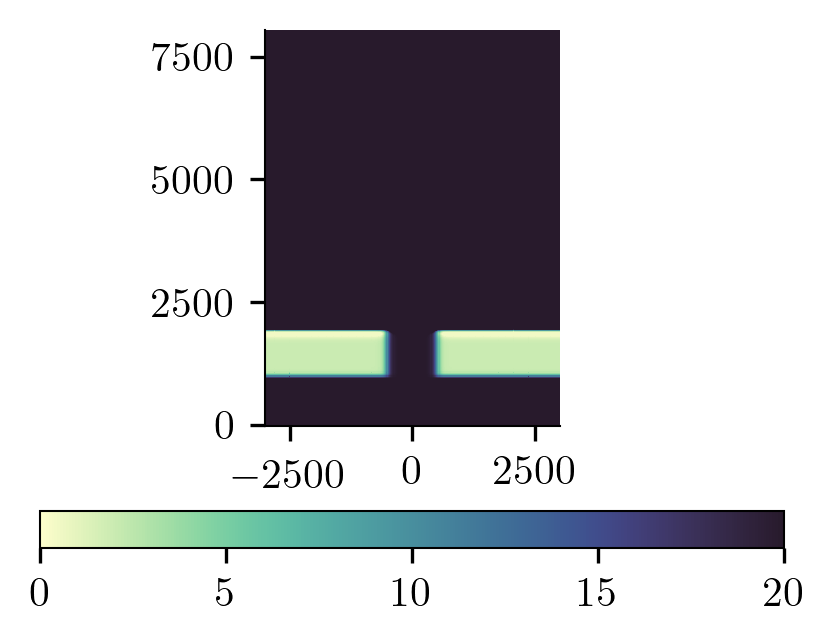

In [10]:
#Plotting
import matplotlib.pyplot as plt
import cmocean

plt.pcolormesh(G.X, G.Y, G.h, vmin = 0, vmax = 20, cmap = cmocean.cm.deep, shading = "auto")
plt.gca().set_aspect("equal")
plt.colorbar(orientation  = "horizontal")

In [254]:
#Output to .mat file
import scipy.io as sio
sio.savemat("reef_bathy.mat", vars(G))


In [ ]:
nc = 1
jf = (2*np.pi)/12 #azimuthal frequency
hj = 20
Nr = int(1024 + 2) #pow2 interior pts
Nt = int(8192 + 2)

Lr = 12e3
Ll = 11e3
Lo = 20e3 
Li = 10e3
Lrc = 100 #reef crest scale
Wj = 500 #jet width
t = np.linspace(0, nc*np.pi/6, int(nc*Nt/12)) - nc*np.pi/12
ri = np.linspace(Li, Lo, Nr)
r = cluster(ri, scale = 1, x0 = 8.5e3)

T,R = np.meshgrid(np.flip(t),r, indexing = "ij")
X,Y = R*np.cos(T), R*np.sin(T)

In [5]:
# def bathy_func(x, h0, scale, offset, hmin = 0, sgn = 1):
#     return h0 + sgn*h0*np.tanh( (x-offset)/scale) + hmin

#h0 = 120, 1.0*8.5e2*skewnorm for 250m deepest
hr = 1.3*8.5e2*skewnorm.pdf(R, a = -2, loc = Lr, scale = 100)
hf = bathy_func(R, h0 = 500, scale = 1.5e3, offset = 15e3, hmin = hj*.8, sgn = 1)  
hl = bathy_func(R, h0 = hj/2, scale = 50, offset = Ll, hmin = 2, sgn = -1) 
t = bathy_func(R, h0 = 0.5, scale = Lrc, offset = Lr, hmin = 0) #transition function

#xp = x % 2*np.pi - np.pi #periodic doesn't work yet)
taperj= tanh2(T, w = 0.5*Wj/(Lr*nc*jf))
hc = R*0 + hj
hlc = hc*taperj + (hl-hr)*(1-taperj)

h = hlc*(1-t) + hf*t
h[h<.5] = .5

z = s2z(h, ns = 30, thetaS = 3.0, thetaB = 2.0, hc  = hj) #thermocline deep as channel
stiffness = rx1(z)
display(f"min depth = {h.min()}")

Maximum rx1-value = 6.661008041795977


'min depth = 0.5095485746601436'

/Users/wit/anaconda3/envs/viz/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


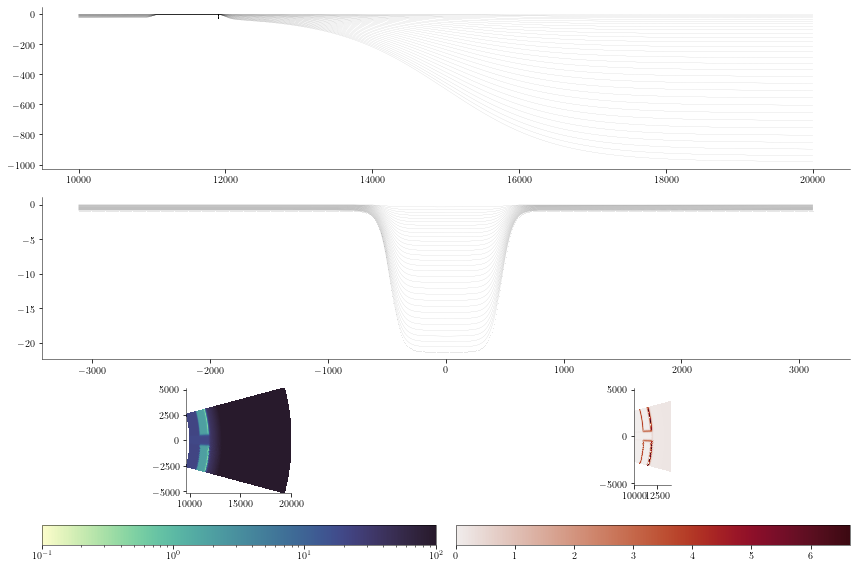

In [6]:
%matplotlib inline
i = 0 #radial slice index
j = np.argmin(abs(R.mean(axis=0)-Lr+100)) #azimuthal slice along reefcrest
arc = R[:,j]*T[:,j]

fig, ax = plt.subplots(3,2, figsize =(12,8))

plt.subplot(3,1,1)
# plt.plot(R.mean(axis = 1), z.mean(axis = 1), color  = "k", linewidth = 0.05)
# plt.scatter(R.mean(axis = 1), -h.mean(axis = 1), s = 0.25, color  = "k", linewidths = 0, marker = ".")
plt.plot(R[i,:], z[i,:], color  = "k", linewidth = 0.05)
plt.scatter(R[:,j], -h[:,j], s = 0.25, color  = "k", linewidths = 0, marker = ".")

plt.subplot(3,1,2)
plt.plot(arc, z[:,j], color  = "k", linewidth = 0.05)
plt.scatter(arc, -h[:,j], s = 0.25, color  = "k", linewidths = 0, marker = ".")

# plt.xlim(10e3, 13e3), plt.ylim(-20, 0)

norm = LogNorm(vmin = 1e-1, vmax = 1e2)
pc = ax[-1,0].pcolormesh(X, Y, h, cmap = cmocean.cm.deep, norm = norm, shading = "auto")
plt.colorbar(pc, ax = ax[-1,0], orientation = "horizontal", pad = 0.2)
ax[-1,0].set_aspect("equal")

pc = ax[-1,1].pcolormesh(X, Y, stiffness[:,:,0], cmap = cmocean.cm.amp, shading = "auto")
plt.colorbar(pc, ax = ax[-1,1], orientation = "horizontal", pad = 0.25)
ax[-1,1].set_xlim(10e3,14e3)
ax[-1,1].set_aspect("equal")

fig.tight_layout()

In [30]:
#Generate .mat file for COAWST mfiles to convert to .nc
grdname = "analytic"

lon, lat = cart2polar(X,Y)
rho = {"lon": lon, "lat": lat, "depth": h, "mask": h*0+1}
projection = "stereographic"
spherical = "T"

# lon, lat = cart2polar(X,Y)
# rho = {"lon": lon, "lat": lat, "depth": h, "mask": h*0+1}
# projection = "stereographic"
# spherical = "T"

# rho = {"x": X, "y": Y, "depth": h, "mask": h*0+1} 
# spherical = "F"
# projection = "mercator"

sio.savemat(f"{grdname}.mat", {"rho": rho, "spherical": spherical, "projection": projection})

In [31]:
eng = matlab.engine.start_matlab()
eng.cd(os.getcwd(),nargout=0)
eng.mat2roms_mw(f"{grdname}.mat", f"{grdname}_grid.nc", nargout=0)
eng.roms2swan( f"{grdname}_grid.nc", nargout=0 )
eng.quit()
os.rename("swan_bathy.bot", f"{grdname}_bathy.bot")
os.rename("swan_coord.grd", f"{grdname}_coord.grd")

In [ ]:
#f-plane
string = fr'''ncap2 -s "f=f*0+{coriolis(-30)};" -O {grdname}_grid.nc {grdname}_grid.nc'''
sp = subprocess.run(string, shell = True, check = True)